# Pauli error estimation via population recovery

This is an implementation of the algorithm in S. T. Flammia and R. O'Donnell, "Pauli error estimation via population recovery", arXiv:2105.02885. 

In [ ]:
exit()

In [1]:
# load the functions
include("PauliEstViaPopRec.jl")

EstAll (generic function with 2 methods)

We consider an example with $n=5$ qubits and $k=25$ nonzero Pauli error probabilities sampled at random. With $m=10^6$ samples, we don't expect to be able to reconstruct error rates with probabilities less than about $10^{-3}$. 

In [2]:
n = 5 # number of qubits
m = 10^6 # number of measurements
k = 25 # size of channel support
δ = 0.1 # probability of some nontrivial error occurring

# Define a Pauli channel as a tuple (p,P), 
# where p is a list of probabilities and P are Pauli row vectors (0,1,2,3)
(p,P) = RandomPauliChannel(n,k,δ)

# get m random probe states
A = rand(Int8.(1:3),m,n)

# Measure the channel (p,P) using the probe states A
R = Measure(A,p,P)

# convert the tuple (p,P) into a dictionary for ease of comparison
pP = sparseP(p,P)

Dict{Vector{Int8}, Float64} with 24 entries:
  [1, 3, 2, 2, 0] => 0.00329709
  [1, 3, 1, 1, 2] => 0.021332
  [2, 3, 0, 2, 1] => 0.00379373
  [3, 2, 3, 1, 3] => 0.00454105
  [0, 2, 2, 2, 3] => 0.00319246
  [0, 1, 0, 3, 3] => 0.00101226
  [3, 2, 3, 3, 0] => 0.00146149
  [3, 0, 3, 1, 3] => 0.00419654
  [3, 0, 3, 2, 0] => 0.00648825
  [2, 2, 3, 3, 0] => 0.00466828
  [1, 2, 0, 3, 1] => 0.00342027
  [2, 0, 3, 2, 1] => 0.0104826
  [2, 0, 2, 1, 0] => 0.00248191
  [0, 1, 3, 1, 1] => 0.00158701
  [3, 0, 1, 0, 2] => 0.00229257
  [2, 1, 3, 0, 2] => 0.00759038
  [3, 0, 1, 1, 2] => 0.00141235
  [1, 0, 0, 3, 1] => 0.000630675
  [2, 3, 3, 0, 0] => 0.00728614
  [0, 0, 0, 0, 0] => 0.9
  [3, 3, 0, 1, 1] => 0.0022903
  [3, 1, 3, 3, 2] => 0.00162164
  [3, 0, 1, 3, 2] => 0.00346166
  [1, 1, 0, 2, 2] => 0.00145924

We can run the algorithm with a specific choice of threshold value for pruning. Here we just choose $1/\sqrt{m}$, even though the rigorous theorem requires using some log factors. 

In [3]:
ϵ = 1/sqrt(m) # pick a simple choice for the thresholding value
@time (q,Q) = EstChan(A,R,ϵ)
qQ = sparseP(q,Q)

  5.710992 seconds (320.76 k allocations: 6.727 GiB, 11.71% gc time, 1.63% compilation time)


Dict{Vector{Int8}, Float64} with 22 entries:
  [1, 3, 1, 1, 2] => 0.0214862
  [1, 3, 2, 2, 0] => 0.00336337
  [0, 2, 2, 2, 3] => 0.00341128
  [2, 3, 0, 2, 1] => 0.00350175
  [3, 2, 3, 1, 3] => 0.00480975
  [3, 2, 3, 3, 0] => 0.00152719
  [3, 0, 3, 1, 3] => 0.00428569
  [2, 2, 3, 3, 0] => 0.00462937
  [3, 0, 3, 2, 0] => 0.00644128
  [1, 2, 0, 3, 1] => 0.00348609
  [2, 0, 3, 2, 1] => 0.0105018
  [2, 0, 2, 1, 0] => 0.00271781
  [0, 1, 3, 1, 1] => 0.00165197
  [3, 0, 1, 0, 2] => 0.00214237
  [2, 1, 3, 0, 2] => 0.00751416
  [3, 0, 1, 1, 2] => 0.00134091
  [2, 3, 3, 0, 0] => 0.00700912
  [0, 0, 0, 0, 0] => 0.899777
  [3, 3, 0, 1, 1] => 0.00233859
  [3, 1, 3, 3, 2] => 0.00161053
  [3, 0, 1, 3, 2] => 0.00360722
  [1, 1, 0, 2, 2] => 0.00163003

We get a pretty accurate reconstruction, as quantified by the TVD.

In [4]:
tvd(pP,qQ)

0.0022216469800768602

What about the estimates that we threw away with our choice of threshold? We can see what those estimates look like by computing all the probability estimates for every Pauli string, even the ones less than $\delta$. We should probably throw away ones that are less than zero, though. What does the TVD look like now? 

In [5]:
@time s = EstAll(A,R)
S = vcat(reverse.(digits.(Int8, findall(x -> x > 0, s) .- 1, base=4,pad=n))'...)
s = s[s .> 0]
sS = sparseP(s,S)
tvd(pP,sS)

 29.174012 seconds (25.59 k allocations: 34.307 GiB, 8.50% gc time)


0.027274649465654742

We can do a scatter plot to compare the complete list of nonnegative estimates to the thresholded values and the "true" values. 

In [6]:
using Plots

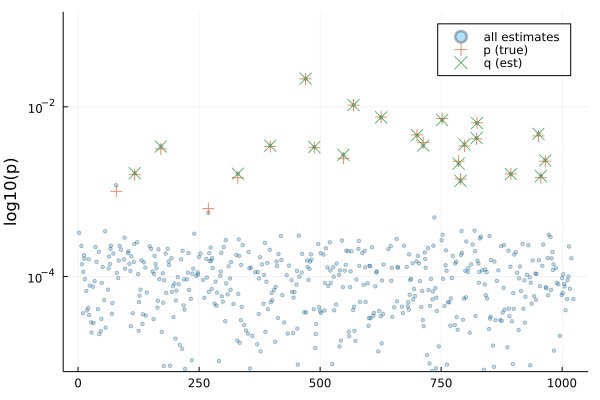

In [7]:
# convert the dictionary values to plotable numbers
keys2num(kK,n) = hcat(collect(keys(kK))...)' * (4 .^((n-1):-1:0))
vals2num(kK) = collect(values(kK))

scatter(keys2num(sS,n), vals2num(sS) , 
    yaxis = ("log10(p)",:log10, [1e-5,1e-1]), 
    label = "all estimates", markeralpha = .3, markersize = 2)
scatter!(keys2num(pP,n), vals2num(pP) , 
    label = "p (true)", markershape = :+, markersize = 6)
scatter!(keys2num(qQ,n), vals2num(qQ) , 
    label = "q (est)", markershape = :x, markersize = 6)